In [ ]:
%load_ext autoreload
%autoreload 2
# Please change the path to the root of the repository
%cd XXXX/VideoActionModel

import os
import pickle
import random
from typing import Any, Dict

import matplotlib.pyplot as plt
import torch
from einops import rearrange

from vam.action_expert import load_inference_VAM
from vam.datalib import CropAndResizeTransform, EgoTrajectoryDataset
from vam.utils import expand_path, read_eval_config

Config = Dict[str, Any]

config = read_eval_config("configs/paths/eval_paths_jeanzay.yaml")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/eramzi/shared/eramzi/NextTokenPredictor


In [ ]:
def get_nuscenes(config: Config, context_length: int) -> EgoTrajectoryDataset:
    with open(expand_path(config["nuscenes"]["pickle"]), "rb") as f:
        pickle_data = pickle.load(f)

    transform = CropAndResizeTransform(resize_factor=3.125, trop_crop_size=0)

    return EgoTrajectoryDataset(
        pickle_data=pickle_data,
        images_rootdir=expand_path(config["nuscenes"]["images_rootdir"]),
        sequence_length=context_length,
        images_transform=transform,
    )


dataset = get_nuscenes(config, 8)

In [ ]:
tokenizer = torch.jit.load(expand_path(config["tokenizer_jit_path"])).to("cuda")

vam_checkpoint_path = "weights/action_expert_116k_attndim768_actdim192.ckpt"
vam = load_inference_VAM(expand_path(vam_checkpoint_path), tempdir=os.environ.get("JOBSCRATCH", "/tmp"))

/home/eramzi/shared/eramzi/NextTokenPredictor/vam/action_expert/video_action_model.py:327: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, m

number of non-embedding parameters: 182.45M
number of non-embedding parameters: 21.35M


Sampled index: 1359


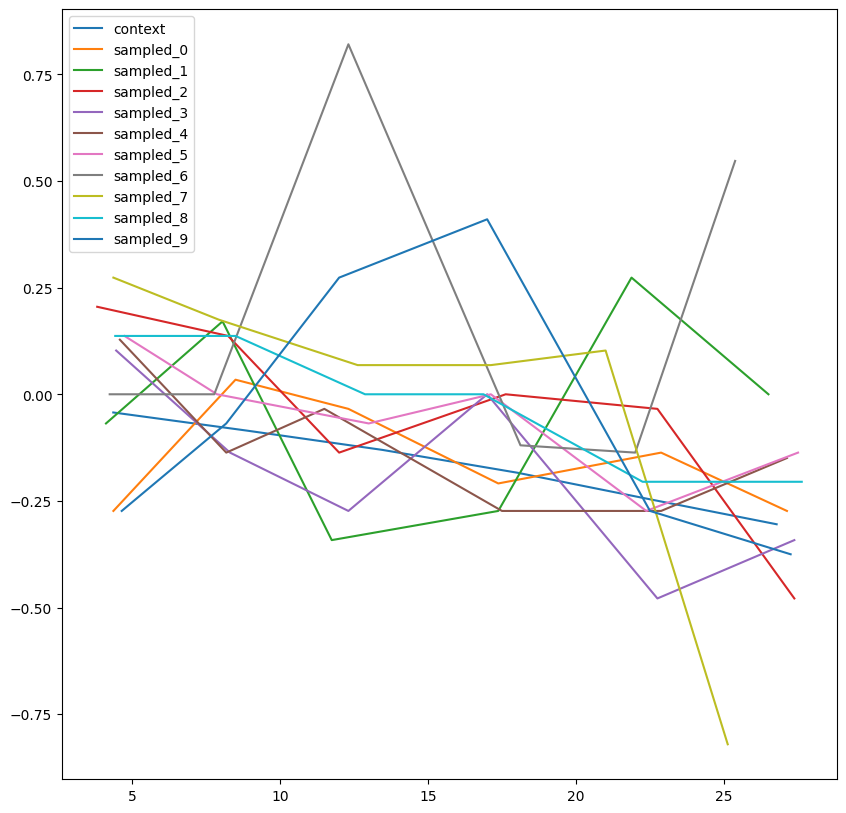

In [38]:
num_sampled_trajectories = 10
num_inference_steps = 3

sampled_idx = random.randint(0, len(dataset) - 1)
sampled_idx = 1359
print(f"Sampled index: {sampled_idx}")
sample = dataset[sampled_idx]
context_length = 5

commands = sample["high_level_command"].to("cuda", non_blocking=True)[context_length - 1 : context_length]
commands = commands.unsqueeze(0)

tokens = tokenizer(sample["image"][:context_length].to("cuda", non_blocking=True))
tokens = rearrange(tokens, "(b t) ... -> b t ...", t=context_length)

sampled_trajectory = []
sampled_intermediate_trajectories = []
for _ in range(num_sampled_trajectories):
    with torch.amp.autocast("cuda", dtype=torch.bfloat16):
        trajectory, intermediate_trajectories = vam(
            tokens, commands, torch.bfloat16, num_inference_steps=num_inference_steps, store_intermediate_states=True
        )
    sampled_trajectory.append(trajectory)
    sampled_intermediate_trajectories.append([traj.float().cpu().detach().numpy() for traj in intermediate_trajectories])

sampled_trajectory = torch.cat(sampled_trajectory, dim=1)
sampled_trajectory = sampled_trajectory.float().cpu().detach().numpy()

plt.figure(figsize=(10, 10))
plt.plot(sample["positions"][context_length - 1][:, 0], sample["positions"][context_length - 1][:, 1], label="context")
for ixd in range(num_sampled_trajectories):
    plt.plot(sampled_trajectory[0, ixd, :, 0], sampled_trajectory[0, ixd, :, 1], label=f"sampled_{ixd}")
plt.legend()

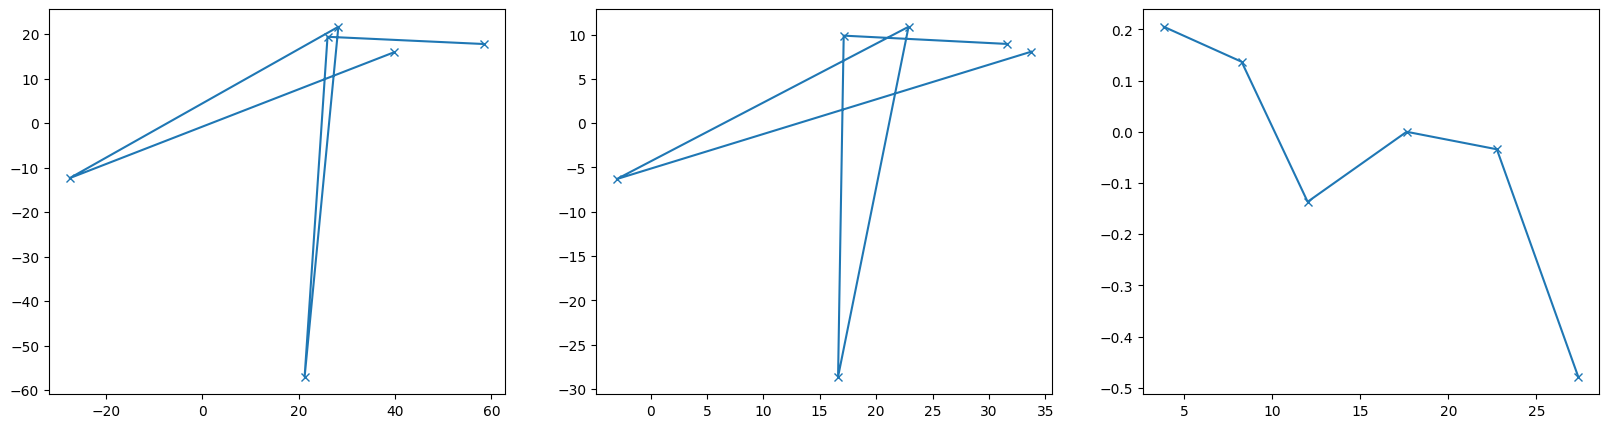

In [41]:
plt.figure(figsize=(20, 5))

for idx, traj in enumerate(sampled_intermediate_trajectories[2]):
    plt.subplot(1, num_inference_steps, idx + 1)
    plt.plot(traj[0, 0, :, 0], traj[0, 0, :, 1], marker="x")